## Why this matters

Teams compare models constantly, and “who wins?” changes by use case:
- **Frontier model bake-offs**: early days, you’re comparing models from different labs on your data to pick a default.
- **Cost vs quality**: compare a cheap vs expensive model variant from the same lab to see if quality loss is worth the savings.
- **Production vs challenger**: test a fine-tuned model, new guardrails, or an improved RAG pipeline against today’s production model.

Human evaluation tells you which model wins and crucially where it wins (by domain or question type), so you can choose the right model, route intelligently, or iterate your prompts/RAG.

## What you’ll build

- A Label Studio project with a rubric: Winner (A/B/Tie) + Quality (1–5) + Notes
- A small demo dataset you can swap for your own
- A Colab that creates the project, imports tasks, fetches annotations, and analyzes results

> Works with Label Studio OSS or Enterprise (we’ll call out optional Enterprise features).

## Prerequisites

- A running Label Studio (OSS or Enterprise) you can reach from Colab or your local Python
   - LS_URL (e.g., http://localhost:8080 or your team URL)
   - LS_API_KEY (personal token)
- Python 3.10+ (Colab is fine)
- ~20–30 minutes to annotate 20 items (solo or with a colleague)

## 0. Setup

We are going to lean on the Label Studio SDK for the whole project so you will need to have at hand two important pieces of information:

1. The base url (`LS_URL`) where your Label Studio instance is running.
2. An `LS_API_KEY` to authenticate your requests.


If Colab can't reach your localhost you can:
1. Run this notebook locally with Jupyter
2. Tunnel the connection with services like ngrok or cloudflared ([ngrok example](https://dashboard.ngrok.com/get-started/setup/macos))

You can create a valid `API_KEY` in the Account & Settings menu of your Label Studio UI (top right corner clicking the you user avatar)

In [ ]:
!pip -q install label-studio-sdk pandas numpy matplotlib scipy

import os
import json
import time
from dataclasses import dataclass
from typing import List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest
from label_studio_sdk import LabelStudio

# For nicer dataframe display in Colab
pd.set_option('display.max_colwidth', 160)

# Configure Label Studio connection
# Note: Colab cannot reach your local http://localhost:8000 unless you tunnel.
# If testing locally, run this notebook in Jupyter, or expose LS via a tunnel.
LS_URL = os.getenv("LS_URL", "http://localhost:8080")  # <-- change if needed
LS_API_KEY = os.getenv("LS_API_KEY", "YOUR_TOKEN")  # <-- set your token

ls = LabelStudio(base_url=LS_URL, api_key=LS_API_KEY)
user = ls.users.whoami()
print("Connected to Label Studio as:", user.username)
print("LS_URL:", LS_URL)


## 1. Create the Label Studio project

### What the project looks like

This project shows: the question, two answers (Model A & B), and a rubric: Winner (A/B/Tie), Overall quality (1–5), and optional Notes.

![Labelling](https://drive.google.com/uc?export=view&id=1CiidMVXfsi8MKfA0IJk0XhtibHVPKp-0)

In [ ]:
LABEL_CONFIG = r"""
<View>
  <Style>
    .candidate { border: 1px solid #ccc; padding: 12px; border-radius: 8px; margin-bottom: 8px; }
    .two-col { display: grid; grid-template-columns: 1fr 1fr; gap: 12px; }
    .prompt { background: #fafafa; padding: 12px; border: 1px dashed #ddd; border-radius: 8px; }
  </Style>

  <Header value="Prompt" />
  <Text name="prompt" value="$prompt" className="prompt" />

  <Header value="Compare answers" />
  <View className="two-col">
    <View className="candidate">
      <Header value="Model A (Claude 4.5 Sonnet)" />
      <Text name="answer_a" value="$answer_a" />
    </View>
    <View className="candidate">
      <Header value="Model B (GPT-5)" />
      <Text name="answer_b" value="$answer_b" />
    </View>
  </View>

  <Header value="Pick a winner" />
  <Choices name="winner" toName="prompt" required="true">
    <Choice value="Model A" />
    <Choice value="Model B" />
    <Choice value="Tie" />
  </Choices>

  <Header value="Overall quality (1-5)" />
  <Rating name="quality" toName="prompt" maxRating="5" icon="star" required="true" />

  <Header value="Notes (optional)" />
  <Textarea name="notes" toName="prompt" placeholder="Why did this model win? Any errors or hallucinations?" />
</View>
"""

project = ls.projects.create(
    title="A/B Model Comparison — Movie Science Fact-Check",
    description="Compare two models on science-in-movies questions and collect human judgments.",
    label_config=LABEL_CONFIG
)

print("Project created with id:", project.id, "| title:", project.title)


Project created with id: 36 | title: A/B Model Comparison — Movie Science Fact-Check


### ✨ LabelStudio Enterprise tip: when this scales up

> Enterprise features help you run larger, faster, higher-quality evaluations:
>
> - **Automatic assignment & queues**: distribute tasks to annotators  automatically, parallelize throughput, and monitor progress per queue. [Learn more about advance configuration options.](https://docs.humansignal.com/guide/setup_project#Configure-high-impact-settings)
> - **Overlap & agreement**: collect multiple judgments per item, compute inter-annotator agreement (IAA), and flag disagreements for review. [Learn more about task agreement and labeling consensus.](https://docs.humansignal.com/guide/stats.html)
> - **Review & consensus**: add a reviewer step that resolves ties/disputes and enforces guidelines. [Learn more about the Reviewer workflow](https://docs.humansignal.com/guide/quality).
> - **Webhooks & automation**: trigger exports or downstream analysis when a batch or project reaches a completion threshold.
>
> Outcome: faster time-to-signal, better label quality, and auditability for model decisions.

## 2. Prepare a tiny dataset and model outputs

For portability, we fabricate 20 prompts and used the output from two LLMs. Replace these functions with your real models or load CSVs.

In [ ]:
np.random.seed(7)

prompts = [
    "In Interstellar, is the extreme time dilation near the black hole plausible under general relativity? Explain briefly.",
    "In The Martian, is growing potatoes in Martian regolith realistic, and what critical step would be required?",
    "In Jurassic Park, could viable dinosaur DNA survive in amber for ~65 million years? Why or why not?",
    "In Gravity, does the cascading debris scenario (Kessler Syndrome) reflect a real orbital risk? Briefly assess.",
    "In Oppenheimer, was critical mass analysis central to the Manhattan Project’s design decisions? One core point.",
    "In Arrival, does the film’s language-learning premise relate to real concepts in linguistics/information theory?",
    "In Apollo 13, is the CO₂ scrubber ‘square peg in round hole’ fix grounded in real engineering constraints?",
    "In Gattaca, is the portrayed level of genetic screening ethically debated in modern genetics? One concise note.",
    "In Armageddon, could a nuclear device realistically ‘blow up’ a large asteroid to avert impact at the last minute?",
    "In Star Wars space battles, is audible sound propagation realistic in vacuum? Why or why not?",
    "In Interstellar, does the depiction of gravitational lensing align with physics consulted by Kip Thorne?",
    "In The Martian, would Martian perchlorates pose a challenge for agriculture without treatment? One line.",
    "In Jurassic Park, are frogs a plausible DNA patch for reconstructing dinosaurs? Scientific assessment, briefly.",
    "In Gravity, is orbital plane matching as trivial as depicted when transferring between spacecraft? One-liner.",
    "In Oppenheimer, is prompt criticality risk a real safety concern in weapons physics? Short answer.",
    "In Arrival, could non-linear language acquisition plausibly alter human temporal perception? Briefly evaluate.",
    "In Apollo 13, does power budgeting and thermal management match real spacecraft constraints?",
    "In Gattaca, is polygenic screening predictive enough today to determine career suitability? One-liner.",
    "In Armageddon, is landing on an asteroid and drilling a viable mitigation strategy compared to deflection?",
    "In Interstellar, could a near-light-speed trip yield significant relativistic aging differences? Short explanation.",
]

def model_a_answer(prompt: str) -> str:
    """Claude 4.5 Sonnet - 8s"""
    templates = [
      "Yes, extreme time dilation near a black hole is plausible under general relativity. The massive gravitational field warps spacetime significantly, causing time to pass much slower relative to distant observers—an effect accurately depicted with physicist Kip Thorne's consultation.",
      "Growing potatoes in Martian regolith is partially realistic but requires critical preprocessing: the soil must be treated to remove toxic perchlorates and supplemented with organic matter and water. The film glosses over the perchlorate remediation step.",
      "No, viable dinosaur DNA could not survive 65 million years in amber. DNA degrades with a half-life of approximately 521 years; even under ideal preservation conditions, fragments beyond ~6 million years old would be unsequenceable.",
      "Yes, the Kessler Syndrome depicted in Gravity reflects a real orbital risk. Cascading collisions creating debris fields that trigger further collisions is a genuine concern for Earth's orbital environment, though the film's timeline is dramatically compressed.",
      "Yes, determining critical mass—the minimum fissile material needed for a self-sustaining chain reaction—was absolutely central to designing both the gun-type (Little Boy) and implosion-type (Fat Man) weapons.",
      "Yes, the premise relates to the Sapir-Whorf hypothesis (linguistic relativity) and concepts in cognitive linguistics suggesting language structure can influence thought patterns, though the film's extreme interpretation (nonlinear time perception) is highly speculative.",
      "Yes, the CO₂ scrubber fix is based on the actual Apollo 13 mission. Engineers on the ground had to devise a solution using only materials available on the spacecraft to adapt Command Module scrubbers for the Lunar Module's different form factor.",
      "Yes, the genetic screening and discrimination portrayed in Gattaca directly parallels ongoing ethical debates around genetic testing, workplace/insurance discrimination, genetic privacy, and the societal implications of genomic medicine.",
      "No, detonating a nuclear device at the last minute is unrealistic. The physics of asteroid breakup would likely create multiple threatening fragments. Early detection with gentle deflection (kinetic impactor or gravity tractor) over years is the viable approach.",
      "No, audible sound propagation in vacuum is not realistic. Sound requires a medium (air, water, etc.) to travel through; space is a near-perfect vacuum, so explosive sounds and engine roars in Star Wars are purely cinematic license.",
      "Yes, Interstellar's gravitational lensing visualization is remarkably accurate. Kip Thorne provided the relativistic equations, and the rendering team produced scientifically valid images of light bending around the black hole Gargantua, even leading to academic papers.",
      "Yes, Martian perchlorates (ClO₄⁻ salts) are toxic to humans and would inhibit plant growth; they must be washed out or chemically treated before regolith can support agriculture.",
      "No, using frog DNA to patch gaps is not scientifically plausible. The genetic distance between amphibians and dinosaurs is enormous, and arbitrarily filling sequence gaps would not yield functional genes for a viable organism.",
      "No, orbital plane matching is far from trivial—it requires enormous amounts of delta-v (velocity change). The film depicts transfers between different orbits as simple maneuvers, when they'd require fuel reserves the spacecraft wouldn't have.",
      "Yes, prompt criticality (sudden uncontrolled chain reaction) is a genuine safety concern in nuclear weapons physics and was a critical risk during Manhattan Project experiments, notably in 'tickling the dragon's tail' incidents.",
      "Highly speculative. While linguistic relativity suggests language influences cognition, there's no scientific evidence that learning a language could fundamentally alter temporal perception to enable 'seeing' future events as Arrival depicts.",
      "Yes, Apollo 13's depiction of power rationing and thermal management constraints closely matches the real mission. The spacecraft had to operate on minimal power to conserve batteries, while managing heat dissipation without normal systems.",
      "No, current polygenic risk scores have limited predictive power for complex traits like intelligence or career aptitude. Most complex phenotypes involve thousands of genetic variants plus environmental factors, making deterministic predictions impossible.",
      "No, landing, drilling, and detonating is far less viable than early deflection. The logistics are extraordinarily complex, and timing is critical. Kinetic impactors or gravity tractors applied years in advance are more feasible mitigation strategies.",
      "Yes, near-light-speed travel would produce dramatic relativistic time dilation. At 99.5% light speed, time aboard the spacecraft would pass roughly 10 times slower than for stationary observers, enabling significant aging differences over long journeys.",
    ]
    return templates[prompts.index(prompt)]

def model_b_answer(prompt: str) -> str:
    """GPT-5 - 52s"""
    templates = [
        "Largely plausible under general relativity near a fast-spinning supermassive black hole, but it requires extreme proximity and fine-tuned orbits with severe constraints.",
        "Partly—plants need a controlled habitat and nutrients, and the critical step is removing toxic perchlorates from the regolith (e.g., leaching/heating) before fertilizing.",
        "No; DNA degrades chemically and would not remain viable for ~65 million years in amber.",
        "Yes, the Kessler Syndrome is a real risk, though the film compresses timelines and simplifies orbital mechanics.",
        "Yes—critical mass and rapid supercritical assembly (implosion for plutonium to avoid pre-initiation) were central design drivers.",
        "Loosely—it nods to linguistic relativity and information theory, but the strong effects portrayed are speculative.",
        "Yes—the LiOH canister mismatch required a real improvised adapter built from available materials under strict constraints.",
        "Yes—this level of genetic screening is actively debated, touching on eugenics, discrimination, and consent.",
        "Unlikely—energy requirements and fragmentation make last-minute nuclear disruption ineffective and risky; earlier deflection is preferred.",
        "No—sound cannot propagate in vacuum because there’s no medium.",
        "Largely yes—the visuals were produced with GR-based ray tracing under Kip Thorne’s guidance, with minor artistic tweaks.",
        "Yes—perchlorates are toxic/oxidizing and must be removed or neutralized before agriculture.",
        "Unlikely—frog DNA is far too divergent to plausibly patch dinosaur genomes in a scientifically credible way.",
        "No—orbital plane changes are delta‑v expensive and timing-sensitive, not trivial.",
        "Yes—prompt criticality is a real safety hazard in weapons physics (e.g., Demon Core incidents).",
        "Very speculative—there’s no evidence language learning can induce non-linear temporal perception in humans.",
        "Yes—tight power budgets and thermal management constraints were real and are accurately depicted.",
        "No—polygenic scores are not predictive enough today to determine individual career suitability.",
        "Generally no—landing and drilling are high-risk; slow-push or kinetic/gravity-tractor deflection is more viable.",
        "Yes—at relativistic speeds, time dilation makes travelers age less than those on Earth; gravitational fields can add further dilation.",
    ]
    return templates[prompts.index(prompt)]

records = [{"prompt": p, "answer_a": model_a_answer(p), "answer_b": model_b_answer(p)} for p in prompts]
df = pd.DataFrame(records)
df


,prompt,answer_a,answer_b
0,"In Interstellar, is the extreme time dilation near the black hole plausible under general relativity? Explain briefly.","Yes, extreme time dilation near a black hole is plausible under general relativity. The massive gravitational field warps spacetime significantly, causing t...","Largely plausible under general relativity near a fast-spinning supermassive black hole, but it requires extreme proximity and fine-tuned orbits with severe..."
1,"In The Martian, is growing potatoes in Martian regolith realistic, and what critical step would be required?",Growing potatoes in Martian regolith is partially realistic but requires critical preprocessing: the soil must be treated to remove toxic perchlorates and s...,"Partly—plants need a controlled habitat and nutrients, and the critical step is removing toxic perchlorates from the regolith (e.g., leaching/heating) befor..."
2,"In Jurassic Park, could viable dinosaur DNA survive in amber for ~65 million years? Why or why not?","No, viable dinosaur DNA could not survive 65 million years in amber. DNA degrades with a half-life of approximately 521 years; even under ideal preservation...",No; DNA degrades chemically and would not remain viable for ~65 million years in amber.
3,"In Gravity, does the cascading debris scenario (Kessler Syndrome) reflect a real orbital risk? Briefly assess.","Yes, the Kessler Syndrome depicted in Gravity reflects a real orbital risk. Cascading collisions creating debris fields that trigger further collisions is a...","Yes, the Kessler Syndrome is a real risk, though the film compresses timelines and simplifies orbital mechanics."
4,"In Oppenheimer, was critical mass analysis central to the Manhattan Project’s design decisions? One core point.","Yes, determining critical mass—the minimum fissile material needed for a self-sustaining chain reaction—was absolutely central to designing both the gun-typ...",Yes—critical mass and rapid supercritical assembly (implosion for plutonium to avoid pre-initiation) were central design drivers.
5,"In Arrival, does the film’s language-learning premise relate to real concepts in linguistics/information theory?","Yes, the premise relates to the Sapir-Whorf hypothesis (linguistic relativity) and concepts in cognitive linguistics suggesting language structure can influ...","Loosely—it nods to linguistic relativity and information theory, but the strong effects portrayed are speculative."
6,"In Apollo 13, is the CO₂ scrubber ‘square peg in round hole’ fix grounded in real engineering constraints?","Yes, the CO₂ scrubber fix is based on the actual Apollo 13 mission. Engineers on the ground had to devise a solution using only materials available on the s...",Yes—the LiOH canister mismatch required a real improvised adapter built from available materials under strict constraints.
7,"In Gattaca, is the portrayed level of genetic screening ethically debated in modern genetics? One concise note.","Yes, the genetic screening and discrimination portrayed in Gattaca directly parallels ongoing ethical debates around genetic testing, workplace/insurance di...","Yes—this level of genetic screening is actively debated, touching on eugenics, discrimination, and consent."
8,"In Armageddon, could a nuclear device realistically ‘blow up’ a large asteroid to avert impact at the last minute?","No, detonating a nuclear device at the last minute is unrealistic. The physics of asteroid breakup would likely create multiple threatening fragments. Early...",Unlikely—energy requirements and fragmentation make last-minute nuclear disruption ineffective and risky; earlier deflection is preferred.
9,"In Star Wars space battles, is audible sound propagation realistic in vacuum? Why or why not?","No, audible sound propagation in vacuum is not realistic. Sound requires a medium (air, water, etc.) to travel through; space is a near-perfect vacuum, so e...",No—sound cannot propagate in vacuum because there’s no medium.


## 3. Import tasks into Label Studio

Use task bulk creation for speed.

In [ ]:
tasks: List[Dict[str, Any]] = df.to_dict(orient="records")
resp = ls.projects.import_tasks(id=project.id, request=tasks, return_task_ids=True)
print("Imported tasks:", resp)

Imported tasks: annotation_count=0 could_be_tasks_list=False data_columns=[] duration=0.04078197479248047 file_upload_ids=[] found_formats=[] predictions_count=None task_count=20 prediction_count=0 task_ids=[483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502]


After importing the tasks you will be able to see them in the LabelStudio UI

![Project Tasks](https://drive.google.com/uc?export=view&id=12JCv53FLyPAPzfBgnYLm7qK7A1BNnEdh)



## 4. Human annotation round

- Label all the items (solo or split).
- Keep decisions concise: Winner (A/B/Tie) + Quality (1–5) + optional notes.

![Labelling](https://drive.google.com/uc?export=view&id=1CiidMVXfsi8MKfA0IJk0XhtibHVPKp-0)


## 5. Export annotations & flatten results

In [ ]:
from label_studio_sdk.core.api_error import ApiError
from pathlib import Path

# Create export job
export_job = ls.projects.exports.create(id=project.id)
export_id = export_job.id
print(f"Created export snapshot: id={export_id}, status={export_job.status}")

# Poll until completed or failed
start = time.time()
timeout_sec = 300
print("Waiting for export snapshot to complete...")

while True:
    job = ls.projects.exports.get(id=project.id, export_pk=export_id)
    elapsed = int(time.time() - start)
    print(f"Export status: {job.status} (elapsed {elapsed}s)")
    if job.status in ("completed", "failed"):
        break
    if time.time() - start > timeout_sec:
        raise TimeoutError(
            f"Export job timed out (id={export_id}, status={job.status})"
        )
    time.sleep(1.0)
if job.status == "failed":
    raise ApiError(status_code=500, body=f"Export failed: {job}")

# Download export as JSON to local file
out_dir = Path("/content")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f"project_{project.id}_export_{export_id}.json"

with open(out_path, "wb") as f:
    for chunk in ls.projects.exports.download(
        id=project.id,
        export_pk=export_id,
        export_type="JSON",
        request_options={"chunk_size": 1024},
    ):
        f.write(chunk)

print(f"Export completed. File saved to: {out_path}")

with open(out_path, "rb") as f:
    export_json = json.load(f)

print("Items loaded:", len(export_json))

Created export snapshot: id=5, status=completed
Waiting for export snapshot to complete...
Export status: completed (elapsed 0s)
Export completed. File saved to: /content/project_36_export_5.json
Items loaded: 20


In [ ]:
# Flatten into a DataFrame
rows = []
for item in export_json:
    data = item.get("data", {})
    anns = item.get("annotations", [])
    if not anns:
        continue
    ann = anns[-1]  # latest annotation
    results = ann.get("result", [])

    winner = None
    quality = None
    notes = None
    for r in results:
        if r.get("from_name") == "winner" and r.get("type") == "choices":
            choices = r.get("value", {}).get("choices", [])
            winner = choices[0] if choices else None
        elif r.get("from_name") == "quality" and r.get("type") == "rating":
            quality = r.get("value", {}).get("rating")
        elif r.get("from_name") == "notes" and r.get("type") == "textarea":
            vals = r.get("value", {}).get("text", [])
            notes = vals[0] if vals else None

    rows.append({
        "prompt": data.get("prompt"),
        "answer_a": data.get("answer_a"),
        "answer_b": data.get("answer_b"),
        "winner": winner,
        "quality": quality,
        "notes": notes
    })

res_df = pd.DataFrame(rows)
print("Labeled items:", len(res_df))
res_df.head()

Labeled items: 20


,prompt,answer_a,answer_b,winner,quality,notes
0,"In Oppenheimer, was critical mass analysis central to the Manhattan Project’s design decisions? One core point.","Yes, determining critical mass—the minimum fissile material needed for a self-sustaining chain reaction—was absolutely central to designing both the gun-typ...",Yes—critical mass and rapid supercritical assembly (implosion for plutonium to avoid pre-initiation) were central design drivers.,Model A,2,None
1,"In Apollo 13, does power budgeting and thermal management match real spacecraft constraints?","Yes, Apollo 13's depiction of power rationing and thermal management constraints closely matches the real mission. The spacecraft had to operate on minimal ...",Yes—tight power budgets and thermal management constraints were real and are accurately depicted.,Model B,4,None
2,"In The Martian, is growing potatoes in Martian regolith realistic, and what critical step would be required?",Growing potatoes in Martian regolith is partially realistic but requires critical preprocessing: the soil must be treated to remove toxic perchlorates and s...,"Partly—plants need a controlled habitat and nutrients, and the critical step is removing toxic perchlorates from the regolith (e.g., leaching/heating) befor...",Model B,3,None
3,"In Interstellar, is the extreme time dilation near the black hole plausible under general relativity? Explain briefly.","Yes, extreme time dilation near a black hole is plausible under general relativity. The massive gravitational field warps spacetime significantly, causing t...","Largely plausible under general relativity near a fast-spinning supermassive black hole, but it requires extreme proximity and fine-tuned orbits with severe...",Model A,5,None
4,"In Jurassic Park, could viable dinosaur DNA survive in amber for ~65 million years? Why or why not?","No, viable dinosaur DNA could not survive 65 million years in amber. DNA degrades with a half-life of approximately 521 years; even under ideal preservation...",No; DNA degrades chemically and would not remain viable for ~65 million years in amber.,Model A,4,None


## 6. Basic analysis: win-rate, CI, and charts

In [ ]:
labeled = res_df.dropna(subset=["winner"])
total = len(labeled)
wins_a = (labeled["winner"] == "Model A").sum()
wins_b = (labeled["winner"] == "Model B").sum()
ties   = (labeled["winner"] == "Tie").sum()

print(f"Total labeled: {total}")
print(f"Model A wins: {wins_a}")
print(f"Model B wins: {wins_b}")
print(f"Ties: {ties}")

# Binomial test for A vs B (ignore ties)
decisive = labeled[labeled["winner"].isin(["Model A", "Model B"])]
n = len(decisive)
a = (decisive["winner"] == "Model A").sum()
b = (decisive["winner"] == "Model B").sum()
print(f"\nDecisive votes: {n} | A: {a} B: {b}")

test = binomtest(a, n, p=0.5, alternative="two-sided") if n > 0 else None
if test:
    win_rate_a = a / n
    ci = test.proportion_ci(confidence_level=0.95)
    ci_low, ci_high = ci.low, ci.high
    print("p-value:", test.pvalue)
    print(f"A win-rate: {win_rate_a:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})")
else:
    win_rate_a, ci_low, ci_high = float("nan"), float("nan"), float("nan")


Total labeled: 20
Model A wins: 10
Model B wins: 6
Ties: 4

Decisive votes: 16 | A: 10 B: 6
p-value: 0.454498291015625
A win-rate: 0.625 (95% CI: 0.354–0.848)


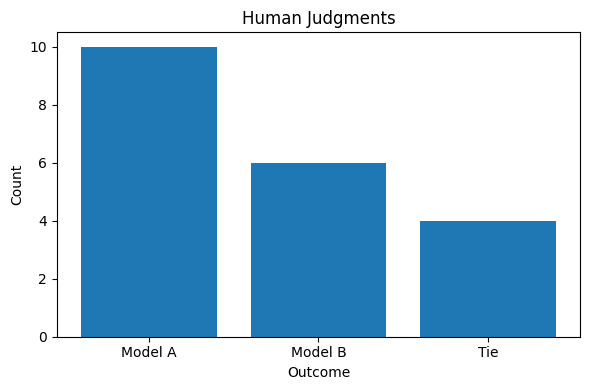

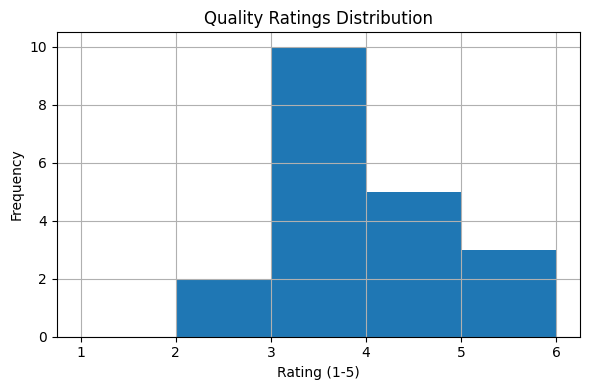

In [ ]:
# Bar chart: A vs B vs Tie
plt.figure(figsize=(6,4))
plt.bar(["Model A", "Model B", "Tie"], [wins_a, wins_b, ties])
plt.title("Human Judgments")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histogram: Quality ratings
labeled["quality"] = pd.to_numeric(labeled["quality"], errors="coerce")
plt.figure(figsize=(6,4))
labeled["quality"].dropna().astype(int).hist(bins=[1,2,3,4,5,6])
plt.title("Quality Ratings Distribution")
plt.xlabel("Rating (1-5)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 7. Interpreting Overall quality (1–5) & using Notes

**What is “Overall quality”?**

A single 1–5 rating for the winning answer on the item. It tells you if wins are convincing (4–5) or fragile (1–3).

**How to act on it**

- **Many 1–2 stars**: the winner barely clears the bar → tighten prompts, add retrieval/grounding, or raise the rubric bar; consider overlap/review to improve label reliability.

- **Mostly 3 stars**: acceptable but not great → look at Notes for quick wins (e.g., “verbose,” “missed perchlorates,” “hand-wavy physics”).

- **Mostly 4–5 stars**: strong signal → safe to switch models or route traffic with confidence.

**Why collect Notes?**

They are gold for root-cause analysis. In 10–20 items you’ll start seeing repeated themes:

> “Hallucination on biology details”, “Confuses plane change Δv”, “Speculative claim stated as fact”, “Too verbose for short answers”.

Turn these into a mini taxonomy (2–6 tags) and measure win-rates per tag next time. That closes the loop between human feedback → concrete fixes.

## 8. Segment analysis: where each model wins (and why it matters)

> We’re not just asking “Who wins overall?” We also want to know where a model wins so decisions are actionable.

**Where do the segments come from?**

- **Scientific domain** is inferred from the movie/topic in each prompt (e.g., Physics/Relativity, Orbital Mechanics/Aerospace, Biology/Genetics, Linguistics/CogSci, Nuclear/Weapons Physics).

- **Question type** categorizes the kind of judgment required (Factual/Physical claim, Engineering judgment, Speculative/Conceptual, Ethics/Societal).


**Why these segments?**

They map to real routing and modeling choices:

- If Model A wins Physics but loses Biology, route physics-like questions to A and biology-like to B, or improve A’s bio grounding (docs, retrieval).
- If A wins Factual but loses Engineering judgment, adjust prompts (ask for trade-offs), or prefer B when decisions need reasoning about constraints.

**What to do with the results?**

- Use the stacked bars to spot strengths/weaknesses per segment.

- For weak segments, sample examples → read Notes → extract failure themes → fix (prompt/RAG/training), then re-run a small eval to confirm.

### 8.1 Segment analysis - by scientific domain

In [ ]:
def infer_domain(p: str) -> str:
    if "Interstellar" in p:
        # time dilation, lensing, relativistic aging
        return "Physics/Relativity"
    if "The Martian" in p:
        return "Planetary/Astro Engineering"
    if "Jurassic Park" in p or "Gattaca" in p:
        return "Biology/Genetics"
    if "Gravity" in p or "Armageddon" in p or "Apollo 13" in p:
        return "Orbital Mechanics/Aerospace"
    if "Oppenheimer" in p:
        return "Nuclear/Weapons Physics"
    if "Arrival" in p:
        return "Linguistics/CogSci/Info"
    if "Star Wars" in p:
        return "Orbital Mechanics/Aerospace"  # sound-in-space → physics/aero edge
    return "Other"

labeled["domain"] = labeled["prompt"].apply(infer_domain)

seg_domain = (labeled[labeled["winner"].isin(["Model A","Model B"])]
              .groupby("domain")["winner"]
              .value_counts()
              .unstack(fill_value=0)
              .sort_index())

seg_domain["total"] = seg_domain["Model A"] + seg_domain["Model B"]
seg_domain["win_rate_A"] = seg_domain["Model A"] / seg_domain["total"].replace(0, pd.NA)
seg_domain.sort_values("win_rate_A", ascending=False)


winner,Model A,Model B,total,win_rate_A
domain,,,,
Nuclear/Weapons Physics,1,0,1,1.000000
Biology/Genetics,2,1,3,0.666667
Physics/Relativity,2,1,3,0.666667
Orbital Mechanics/Aerospace,3,2,5,0.600000
Linguistics/CogSci/Info,1,1,2,0.500000
Planetary/Astro Engineering,1,1,2,0.500000


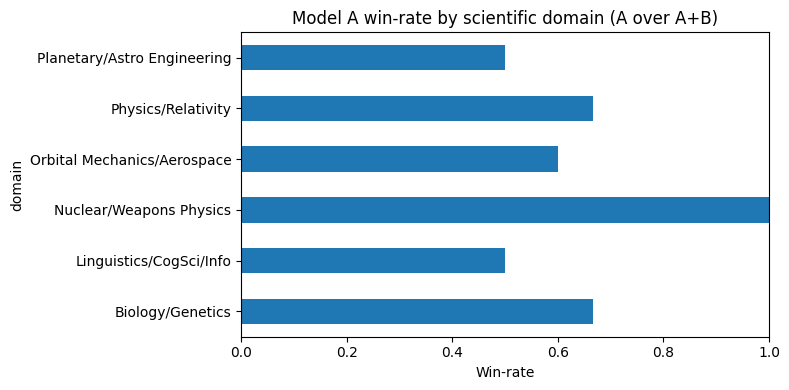

In [ ]:
ax = seg_domain["win_rate_A"].plot(kind="barh", figsize=(8,4))
ax.set_title("Model A win-rate by scientific domain (A over A+B)")
ax.set_xlabel("Win-rate")
ax.set_xlim(0,1)
plt.tight_layout(); plt.show()


### 8.2 Segment analysis - by question type

In [ ]:
def infer_qtype(p: str) -> str:
    if any(k in p for k in ["plausible", "realistic", "feasible", "viable", "real risk"]):
        return "Factual/Physical Claim"
    if any(k in p for k in ["ethically", "debated", "privacy", "discrimination"]):
        return "Ethics/Societal"
    if any(k in p for k in ["speculative", "non-linear", "temporal perception"]):
        return "Speculative/Conceptual"
    if any(k in p for k in ["power", "thermal", "plane matching", "deflection", "scrubber"]):
        return "Engineering Judgment"
    return "General Fact-Check"

labeled["qtype"] = labeled["prompt"].apply(infer_qtype)

seg_qtype = (labeled[labeled["winner"].isin(["Model A","Model B"])]
             .groupby("qtype")["winner"]
             .value_counts()
             .unstack(fill_value=0))

seg_qtype["win_rate_A"] = seg_qtype["Model A"] / (seg_qtype["Model A"] + seg_qtype["Model B"]).replace(0, pd.NA)
seg_qtype.sort_values("win_rate_A", ascending=False)


winner,Model A,Model B,win_rate_A
qtype,,,
Ethics/Societal,1,0,1.000000
Speculative/Conceptual,1,0,1.000000
Engineering Judgment,2,1,0.666667
General Fact-Check,3,2,0.600000
Factual/Physical Claim,3,3,0.500000


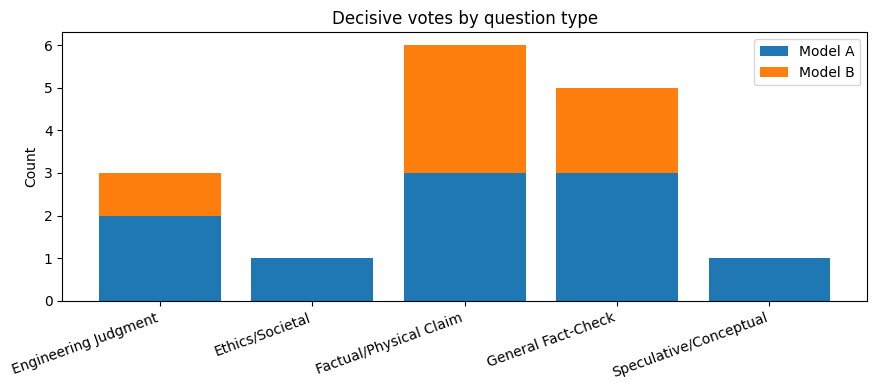

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

seg_qtype_counts = seg_qtype[["Model A", "Model B"]].fillna(0).astype(int)
seg_qtype_counts = seg_qtype_counts.sort_index()  # or .reindex(custom_order)

x = np.arange(len(seg_qtype_counts.index))
a_counts = seg_qtype_counts["Model A"].values
b_counts = seg_qtype_counts["Model B"].values

plt.figure(figsize=(9, 4))
plt.bar(x, a_counts, label="Model A")
plt.bar(x, b_counts, bottom=a_counts, label="Model B")
plt.title("Decisive votes by question type")
plt.ylabel("Count")
plt.xticks(x, seg_qtype_counts.index.astype(str), rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Markdown report

In [ ]:
summary = f"""
# A/B Human Evaluation — Summary

**Total labeled:** {total}
**Model A wins:** {wins_a}
**Model B wins:** {wins_b}
**Ties:** {ties}

**Decisive votes:** {n}
**A win-rate:** {win_rate_a:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})
**p-value:** {getattr(test, 'pvalue', float('nan')):.4f}

**Average quality:** {labeled['quality'].mean():.2f}

**Notes**
- 20 prompts focused on science-in-movies; swap for your own domain easily.
- Keep 20–50 items for a fast, meaningful live demo.
- Consider adding rubric tags (e.g., hallucination, factual error, style) for deeper slices.
"""

with open("report.md", "w") as f:
    f.write(summary)

from datetime import datetime
print(summary)
print("\nSaved report.md at", datetime.now())


# A/B Human Evaluation — Summary

**Total labeled:** 20
**Model A wins:** 10
**Model B wins:** 6
**Ties:** 4

**Decisive votes:** 16
**A win-rate:** 0.625 (95% CI: 0.354–0.848)
**p-value:** 0.4545

**Average quality:** 3.45

**Notes**
- 20 prompts focused on science-in-movies; swap for your own domain easily.
- Keep 20–50 items for a fast, meaningful live demo.
- Consider adding rubric tags (e.g., hallucination, factual error, style) for deeper slices.


Saved report.md at 2025-10-03 10:08:15.757664


## Conclusion: what we learned & what to do next

- We ran a reproducible A/B human eval in minutes: project via SDK → import → annotate → export → charts.
- Beyond “A beats B,” segment charts showed where the wins come from (by domain and question type).
- Quality scores told us how convincing the wins are; Notes surfaced fixable failure themes.

Next steps for a team:

1. Pick a go-live policy (switch default model, or route by segment).
2. Implement two quick fixes from Notes (prompt tweak, RAG doc addition, guardrail).
3. Re-run a small overlap eval (Enterprise) to confirm quality moves in the right direction.
4. Automate: webhook → export → metric notebook → share report.